## Imports

In [ ]:
import kagglehub

import tensorflow as tf
import keras
from keras import Sequential, Input, regularizers
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import numpy as np

import random

import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Set random state for reproducibility
random_state = 23
random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

2026-01-10 11:00:13.907338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768042814.099284      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768042814.171541      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768042814.642414      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768042814.642456      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768042814.642459      24 computation_placer.cc:177] computation placer alr

In [ ]:
# Set base path for datasets and common info
# IF YOU ARE NOT USING KAGGLE
BASE_PATH = kagglehub.dataset_download("mattiaingrassia/gtzan-2-0")
BASE_PATH += "/Augmented_GTZAN/"
# IF YOU ARE USING KAGGLE, ADD THE DATASET 2.0 TO THE NOTEBOOOK, COMMENT THE TWO PREVIOUS LINES AND UNCOMMENT THE FOLLOWING ONE
# BASE_PATH = "/kaggle/input/gtzan-2-0/Augmented_GTZAN/"

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
NUM_CLASSES = len(GENRES)

original_spatial_shape = (288, 432)
original_shape = (288, 432, 4)
cropped_spatial_shape = (217, 335)
cropped_shape = (217, 335, 4)
performances = {}

In [ ]:
# Plot functions
sns.set_style("darkgrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 11

train_color = "#2E86AB"  # Deep blue
val_color = "#A23B72"    # Deep magenta

color_palette = ["#a6cee3", "#1f78b4","#b2df8a", "#33a02c","#fb9a99","#e31a1c"]
model_versions = ["0.0", "1.0", "1.1", "1.2", "1.3", "1.4"]
model_color_map = dict(zip(model_versions, color_palette))

def plot_loss(history):
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 6))

    plt.plot(epochs, loss, linewidth=2.5, label="Training Loss", color=train_color, marker='o', markersize=4, alpha=0.8)
    plt.plot(epochs, val_loss, linewidth=2.5, label="Validation Loss", color=val_color, marker='s', markersize=4, alpha=0.8)

    plt.title("Model Loss Over Training", fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=12, fontweight='semibold')
    plt.ylabel("Loss", fontsize=12, fontweight='semibold')
    plt.legend(loc='upper right', frameon=True, shadow=True, fontsize=11)
    plt.grid(True, alpha=0.5, linestyle='--')

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

def plot_accuracy(history):
    acc = history.history.get("accuracy")
    val_acc = history.history.get("val_accuracy")
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, linewidth=2.5, label="Training Accuracy", color=train_color, marker='o', markersize=4, alpha=0.8)
    plt.plot(epochs, val_acc, linewidth=2.5, label="Validation Accuracy", color=val_color, marker='s', markersize=4, alpha=0.8)

    plt.title("Model Accuracy Over Training", fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=12, fontweight='semibold')
    plt.ylabel("Accuracy", fontsize=12, fontweight='semibold')
    plt.ylim(0, 1.01)
    plt.legend(loc='lower right', frameon=True, shadow=True, fontsize=11)
    plt.grid(True, alpha=0.5, linestyle='--')

    ax = plt.gca()
    ax.set_yticks(np.arange(0.1, 1.01, 0.1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_test, y_pred, model_version):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(
        cm,
        xticklabels=GENRES,
        yticklabels=GENRES,
        cmap="mako",
        annot=True,
        fmt="d"
    )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Model {model_version}")
    plt.tight_layout()
    plt.show()

def plot_classwise_metrics(classification_dict, model_version, color):
    classes = [str(i) for i in range(NUM_CLASSES)]
    
    precision = [classification_dict[c]["precision"] for c in classes]
    recall = [classification_dict[c]["recall"] for c in classes]
    f1 = [classification_dict[c]["f1-score"] for c in classes]

    x = np.arange(NUM_CLASSES)

    metrics = {
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

    for metric_name, values in metrics.items():
        plt.figure(figsize=(12, 6))
        plt.bar(x, values, color=color, edgecolor="#222222")
        plt.xticks(x, GENRES, rotation=90)
        plt.ylim(0, 1.01)
        ax = plt.gca()
        ax.set_yticks(np.arange(0.1, 1.0, 0.1))
        plt.xlabel("Class")
        plt.ylabel(metric_name)
        plt.title(f"Class-wise {metric_name} - Model {model_version}")
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

def plot_overall_metrics(model_metrics, model_version):
    metric_names = ["accuracy", "precision", "recall", "f1-score"]
    values = [model_metrics[m] for m in metric_names]
    plt.figure(figsize=(8, 6))
    plt.bar(metric_names, values, color=model_color_map[model_version], edgecolor="#222222")
    plt.ylim(0, 1.01)
    ax = plt.gca()
    ax.set_yticks(np.arange(0.1, 1.0, 0.1))
    plt.ylabel("Score")
    plt.title(f"Overall Performance Metrics - Model {model_version}")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_model_performance_radar(models_performances):
    metrics = ["accuracy", "precision", "recall", "f1-score"]
    num_metrics = len(metrics)

    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.capitalize() for m in metrics])
    ax.tick_params(axis='x', pad=15)

    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.7, 0.8, 1])
    #ax.set_yticklabels(["0", "0", "", "0.6", "0.7", "", "", "1"])

    for model_name, scores in models_performances.items():
        version = model_name[-3:]
        values = [scores[m] for m in metrics]
        values += values[:1]

        ax.plot(angles, values, color=model_color_map[version], linewidth=2, label=model_name)
        ax.fill(angles, values, alpha=0.1)

    

    ax.set_title("Model Performance Comparison", pad=45)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout()
    plt.show()

In [3]:
def create_report(y_true, preds, model_version):
    y_true_int = np.argmax(y_true, axis = 1)
    preds_int = np.argmax(preds, axis = 1)
    report = classification_report(y_true_int, preds_int, output_dict = True)
    plot_classwise_metrics(report, model_version, model_color_map[model_version])
    return report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']
        
def process(image, label):
    # Normalize the input images
    image = tf.cast(image/255., tf.float32)
    return image, label

In [4]:
def get_dataset(path, image_size, shuffle = True):
    ds = keras.utils.image_dataset_from_directory(
        directory= path,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgba',
        batch_size=32,
        seed=random_state,
        shuffle=shuffle,
        image_size=image_size
    )
    
    # Pre process the dataset
    ds = ds.map(process)
    return ds

def create_naive_CNN_archi(input_shape, model_version, learning_rate=1e-4):
    model =  Sequential([
        Input(shape=input_shape),
        Conv2D(32, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Conv2D(64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(NUM_CLASSES, activation = "softmax")
    ], name = model_version)
    
    model.summary()
    
    model.compile(
       metrics = ["accuracy"],
       loss = "categorical_crossentropy",
       optimizer = Adam(learning_rate=learning_rate)
    )
    
    return model

def create_improved_CNN_archi(input_shape, model_version, learning_rate=1e-4):
    model = Sequential([
            Input(shape=input_shape),
            Conv2D(64, kernel_size=6, activation="relu"),
            MaxPool2D(pool_size=6),
            Conv2D(128, kernel_size=4, activation="relu"),
            MaxPool2D(pool_size=4),
            Conv2D(256, kernel_size=4, activation="relu"),
            MaxPool2D(pool_size=4),
            Flatten(),
            Dropout(0.5),
            Dense(128, activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3)),
            Dropout(0.3),
            Dense(NUM_CLASSES, activation = "softmax")
        ], name = model_version)
    
    model.summary()
    
    model.compile(
       metrics = ["accuracy"],
       loss = "categorical_crossentropy",
       optimizer = Adam(learning_rate=learning_rate)
    )
    
    return model

def fit_and_get_report(model, train_ds, test_ds, validation_ds, epochs = 150, patience = 6):
    history = model.fit(
       train_ds,
       epochs = epochs,
       validation_data = validation_ds,
       callbacks = [EarlyStopping(patience=patience, monitor="val_loss", restore_best_weights=True)]
    )

    plot_accuracy(history)
    plot_loss(history)
        
    y_pred = model.predict(test_ds)
    y_pred_int = np.argmax(y_pred, axis = 1)
    
    y_test = np.concatenate([
        np.argmax(y.numpy(), axis=1)
        for _, y in test_ds
    ])

    plot_confusion_matrix(y_test, y_pred_int, model.name)
    return create_report(to_categorical(y_test), y_pred, model.name)

## Model 0.0
Naive CNN architecture on Original Images (baseline)

Found 719 files belonging to 10 classes.


I0000 00:00:1768042827.701877      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 80 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


Model: "0.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 286, 430, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 143, 215, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 141, 213, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 70, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 474880)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │     4,748,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,768,490 (18.19 MB)

 Trainable params: 4,768,490 (18.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1768042831.564730      70 service.cc:152] XLA service 0x7d0b084050d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768042831.564769      70 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768042831.940788      70 cuda_dnn.cc:529] Loaded cuDNN version 91002


 2/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.1016 - loss: 2.6589

I0000 00:00:1768042838.050444      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.1299 - loss: 2.8336 - val_accuracy: 0.2000 - val_loss: 2.1326
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.1983 - loss: 2.0984 - val_accuracy: 0.2750 - val_loss: 1.8766
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.3877 - loss: 1.7902 - val_accuracy: 0.3250 - val_loss: 1.7505
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5106 - loss: 1.5217 - val_accuracy: 0.4375 - val_loss: 1.6552
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6223 - loss: 1.3339 - val_accuracy: 0.4750 - val_loss: 1.5424
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7054 - loss: 1.0960 - val_accuracy: 0.5250 - val_loss: 1.4118
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7764 - loss: 0.9095 - val_accuracy: 0.5000 - val_loss: 1.5807
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7811 - loss: 0.8434 - val_accuracy: 0.5375 - val_loss: 

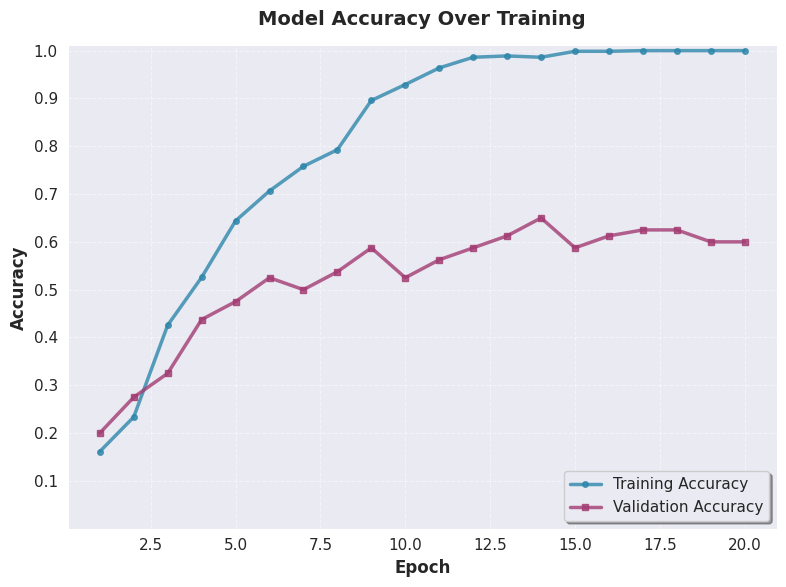

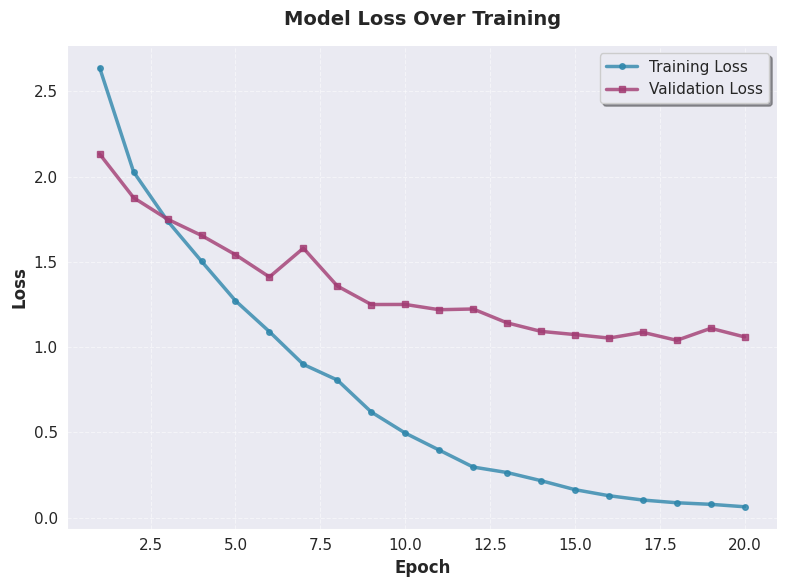

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step


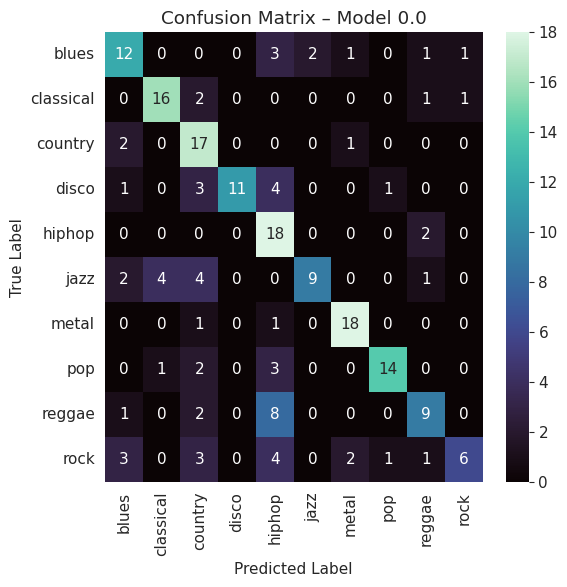

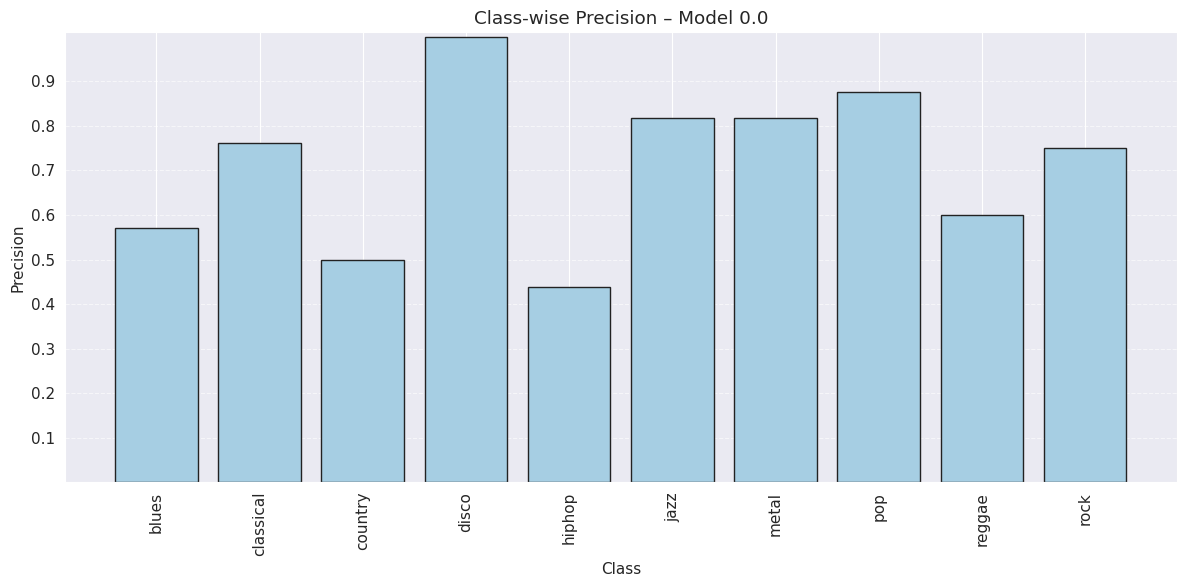

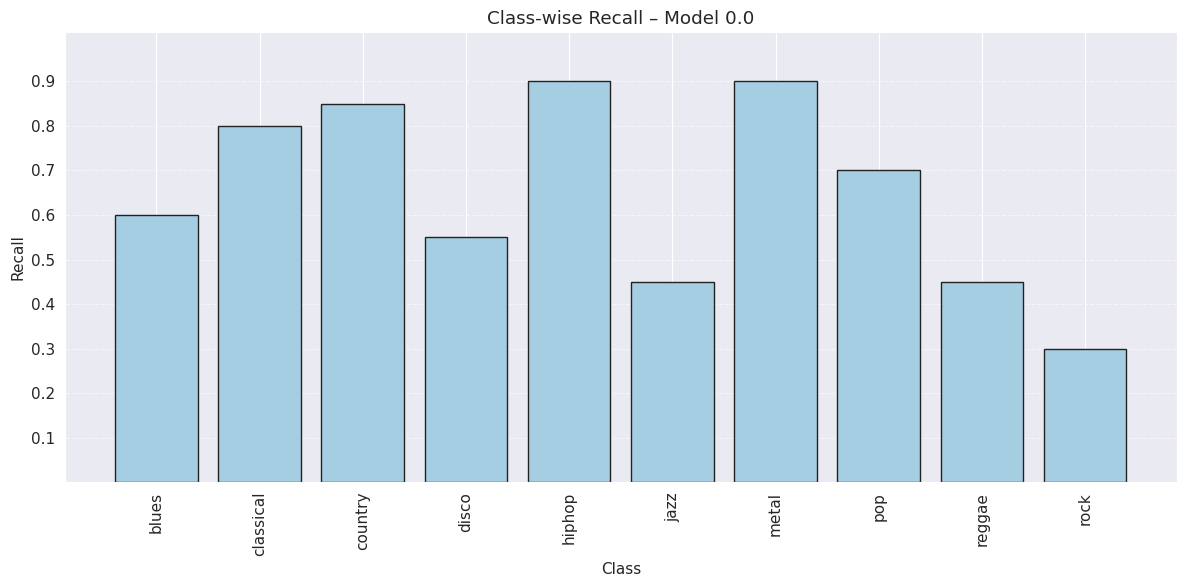

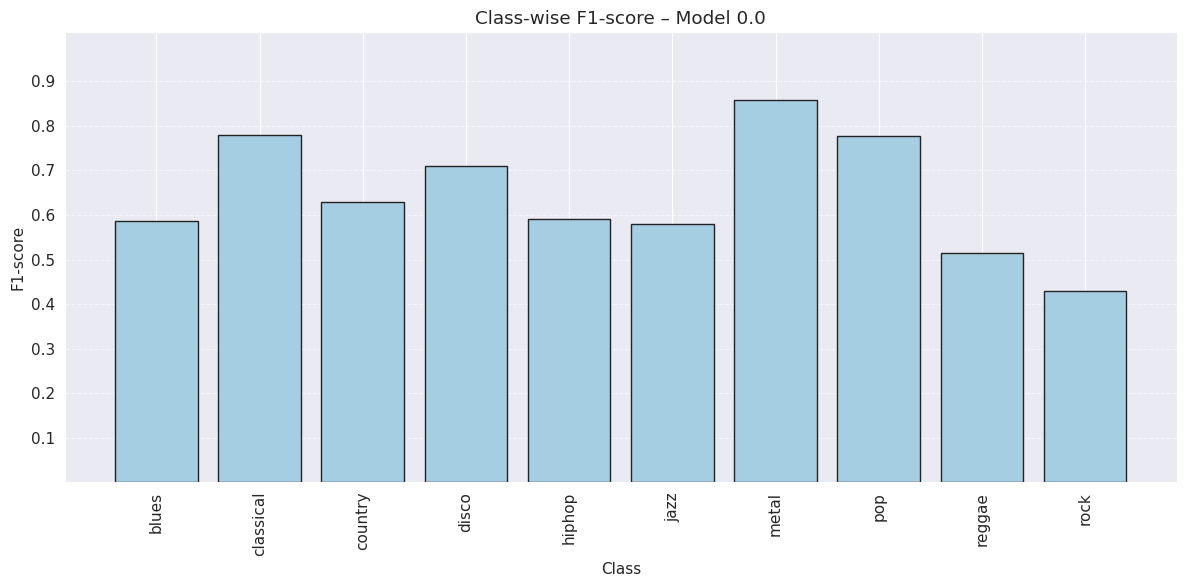

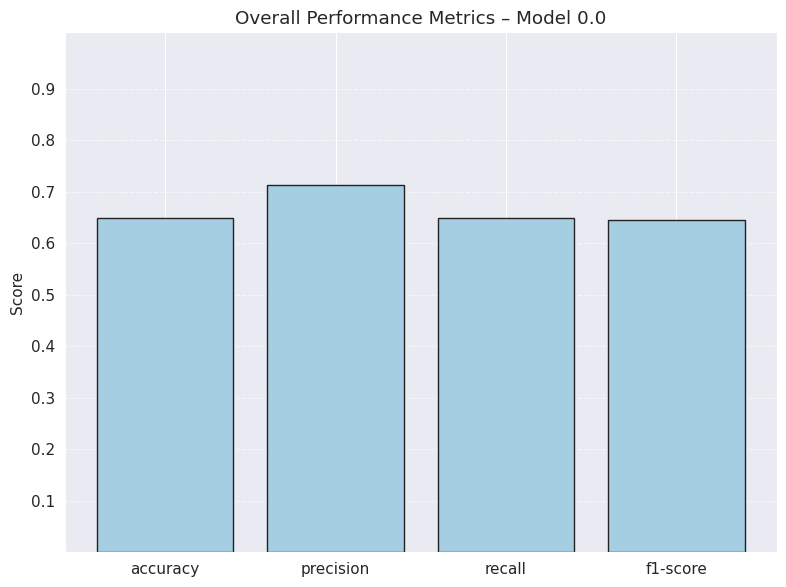

In [ ]:
# Set the current path
cur_path = BASE_PATH + "original"
model_version = "0.0"
model_name = 'Model - ' + model_version

# Load corresponding datasets
train_ds = get_dataset(cur_path + '/train', original_spatial_shape)
val_ds = get_dataset(cur_path + '/val', original_spatial_shape)
test_ds = get_dataset(cur_path + '/test', original_spatial_shape, False)

# Create the model
model = create_naive_CNN_archi(original_shape, model_version)

# Fit the model and get the report
accuracy, precision, recall, f1_score = fit_and_get_report(model, train_ds, test_ds, val_ds, epochs = 20)

# Save the performances in the dictionary
performances[model_name] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}

plot_overall_metrics(performances[model_name], model_version)

## Model 1.0
Improved CNN architecture on Original Images

Found 719 files belonging to 10 classes.
Found 80 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


Model: "1.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 283, 427, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 44, 68, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 14, 256)     │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,050 (3.29 MB)

 Trainable params: 863,050 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2026-01-10 11:01:25.527978: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bw-filter.3 = (f32[64,4,6,6]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,4,288,432]{3,2,1,0} %bitcast.7261, f32[32,64,283,427]{3,2,1,0} %bitcast.7869), window={size=6x6}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/1.0_1/conv2d_2_1/convolution/Conv2DBackpropFilter" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-01-10 11:01:26.016314: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.488452789s
Trying algorithm eng0{} for conv %

23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 392ms/step - accuracy: 0.1022 - loss: 8.3806 - val_accuracy: 0.1000 - val_loss: 8.1100
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1074 - loss: 8.0413 - val_accuracy: 0.1875 - val_loss: 7.7769
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1286 - loss: 7.7088 - val_accuracy: 0.1625 - val_loss: 7.4486
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1331 - loss: 7.3877 - val_accuracy: 0.1750 - val_loss: 7.1221
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1563 - loss: 7.0574 - val_accuracy: 0.3000 - val_loss: 6.7826
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1895 - loss: 6.7400 - val_accuracy: 0.2875 - val_loss: 6.4450
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2043 - loss: 6.4145 - val_accuracy: 0.3375 - val_loss: 6.1058
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1695 - loss: 6.1312 - val_accuracy: 0.2750 - val

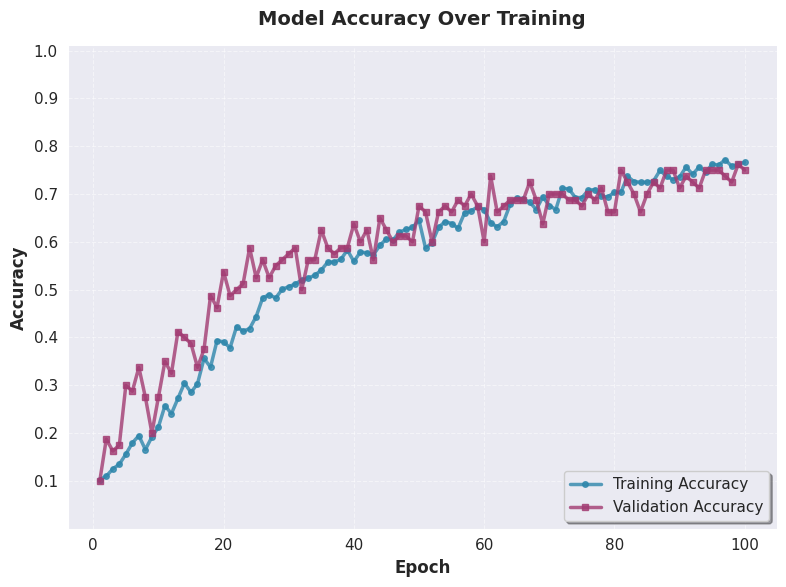

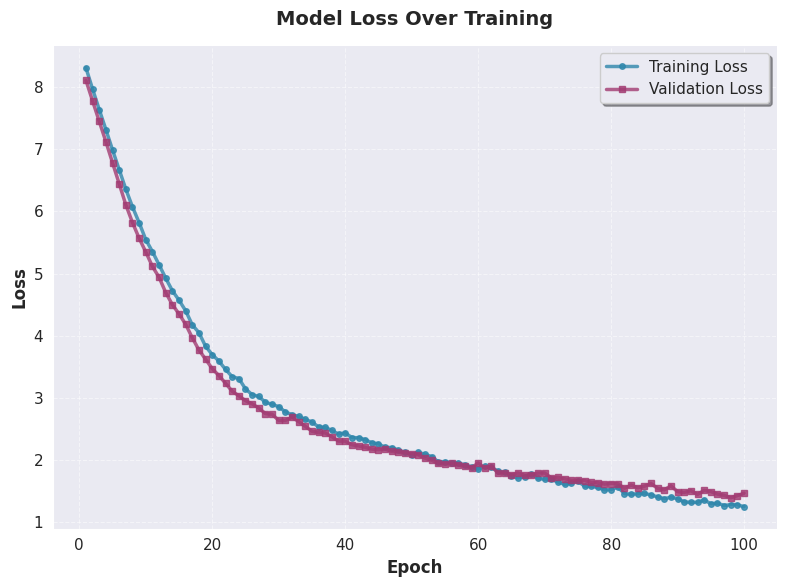

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


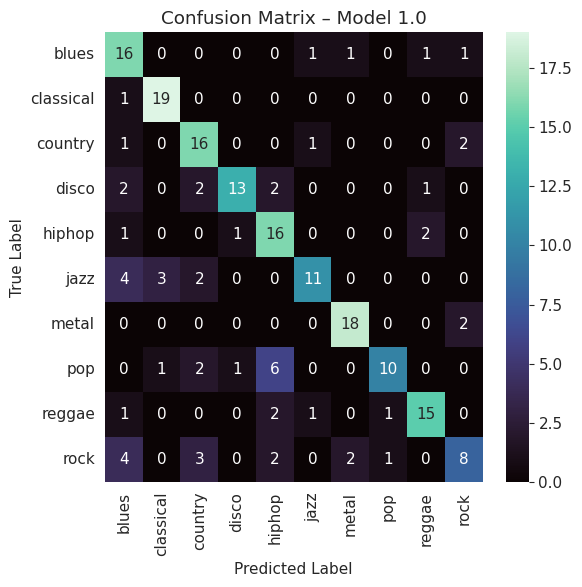

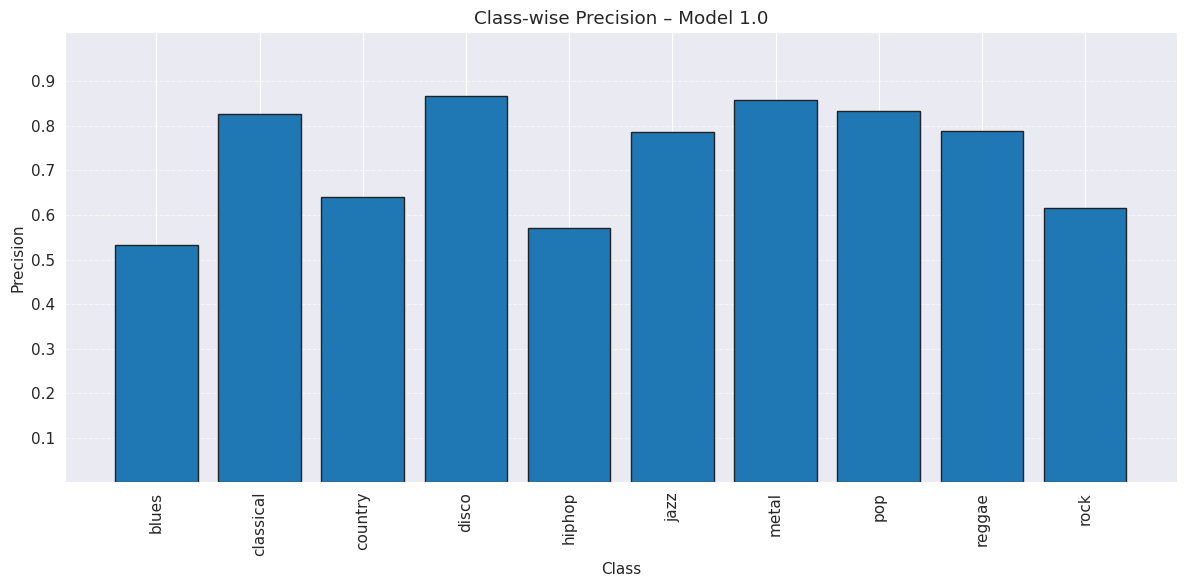

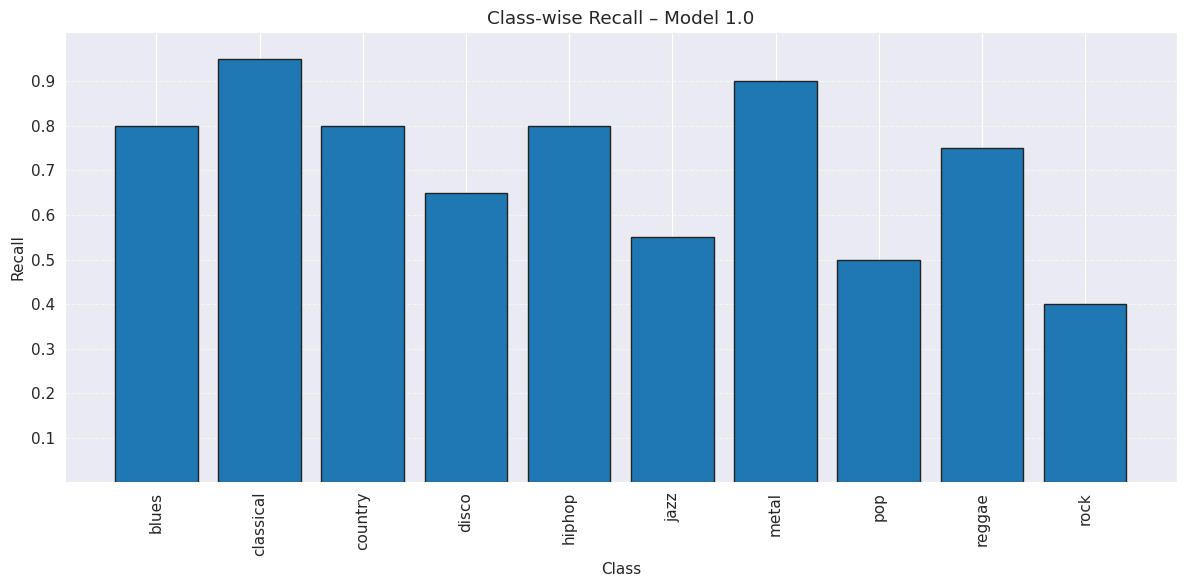

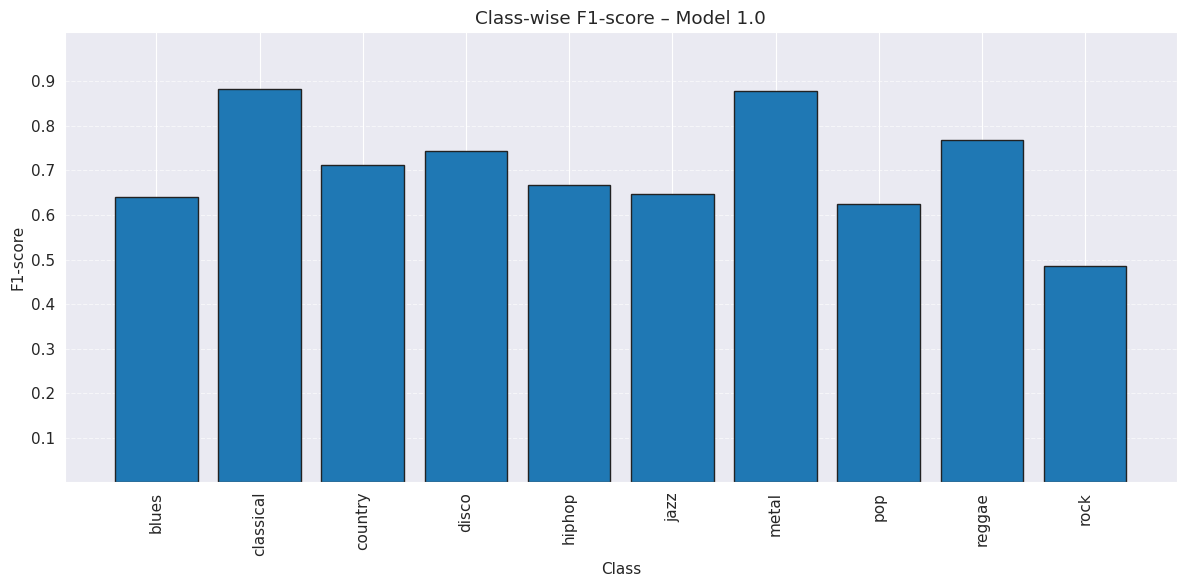

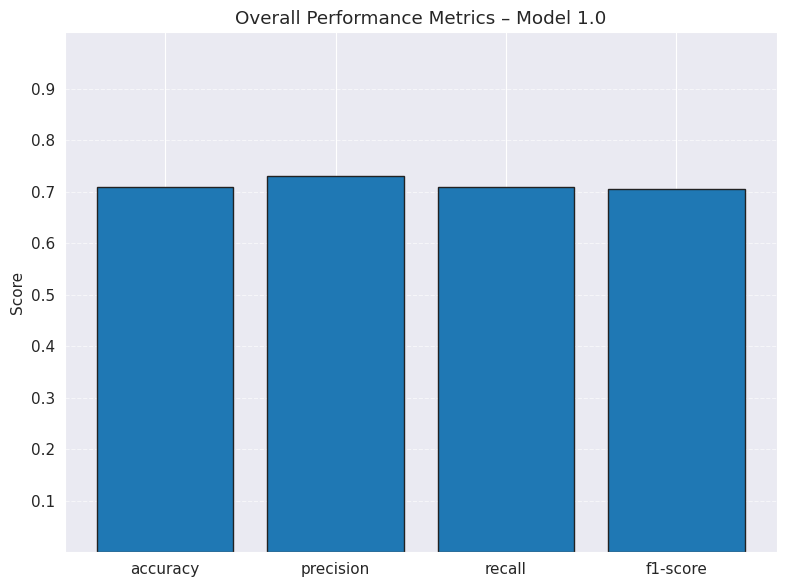

In [ ]:
# Set the current path
cur_path = BASE_PATH + "original"
model_version = "1.0"
model_name = "Model - " + model_version

# Load corresponding datasets
train_ds = get_dataset(cur_path + '/train', original_spatial_shape)
val_ds = get_dataset(cur_path + '/val', original_spatial_shape)
test_ds = get_dataset(cur_path + '/test', original_spatial_shape, False)

# Create the model
model = create_improved_CNN_archi(original_shape, model_version)

# Fit the model and get the report
accuracy, precision, recall, f1_score = fit_and_get_report(model, train_ds, test_ds, val_ds, epochs=100)

# Save the performances in the dictionary
performances[model_name] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}

plot_overall_metrics(performances[model_name], model_version)

## Model 1.1
Improved CNN architecture on Cropped Images

Found 719 files belonging to 10 classes.
Found 80 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


Model: "1.1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 212, 330, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 35, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 52, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 13, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 10, 256)     │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 731,978 (2.79 MB)

 Trainable params: 731,978 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 317ms/step - accuracy: 0.1031 - loss: 5.6622 - val_accuracy: 0.1000 - val_loss: 5.5498
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.1115 - loss: 5.5189 - val_accuracy: 0.1250 - val_loss: 5.4213
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.1201 - loss: 5.3915 - val_accuracy: 0.1625 - val_loss: 5.2799
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.1188 - loss: 5.2651 - val_accuracy: 0.1125 - val_loss: 5.1292
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.1760 - loss: 5.1271 - val_accuracy: 0.1875 - val_loss: 4.9772
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1583 - loss: 4.9803 - val_accuracy: 0.1625 - val_loss: 4.8049
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.1810 - loss: 4.8302 - val_accuracy: 0.2375 - val_loss: 4.6427
Epoch 8/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.2003 - loss: 4.6817 - val_accuracy: 

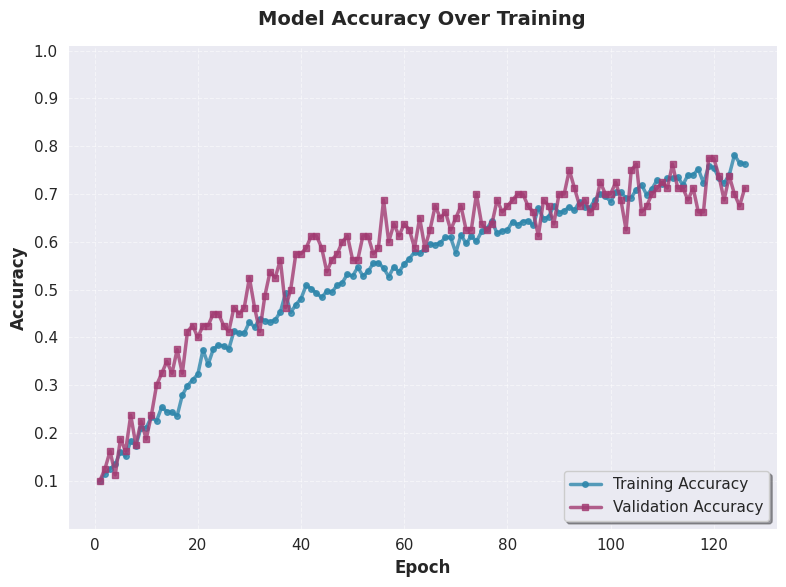

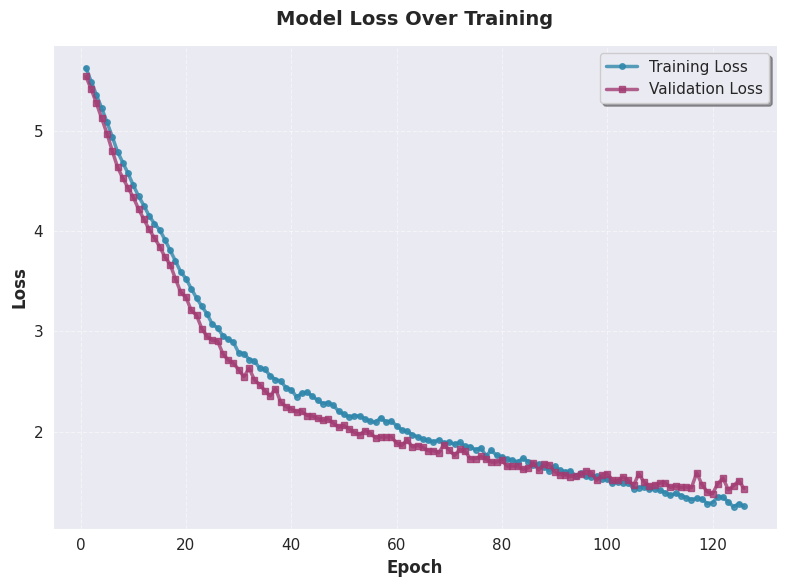

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


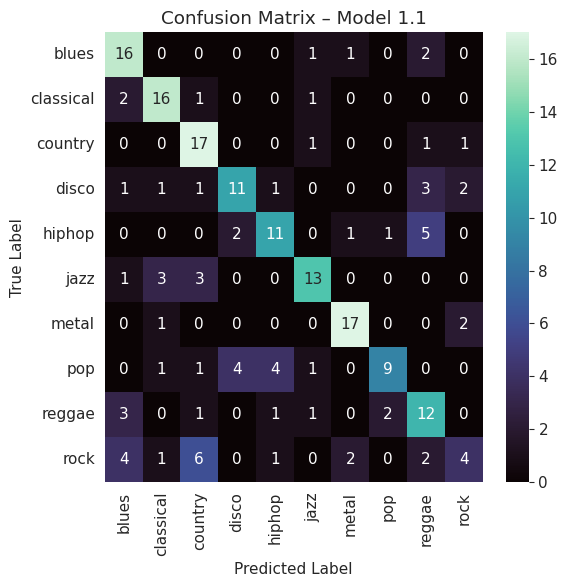

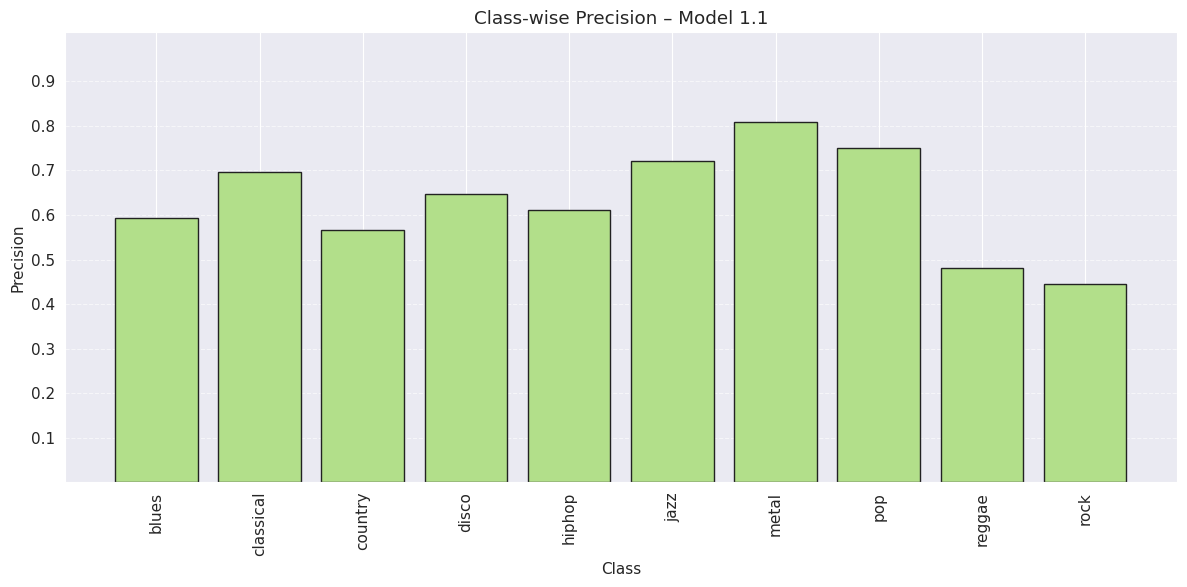

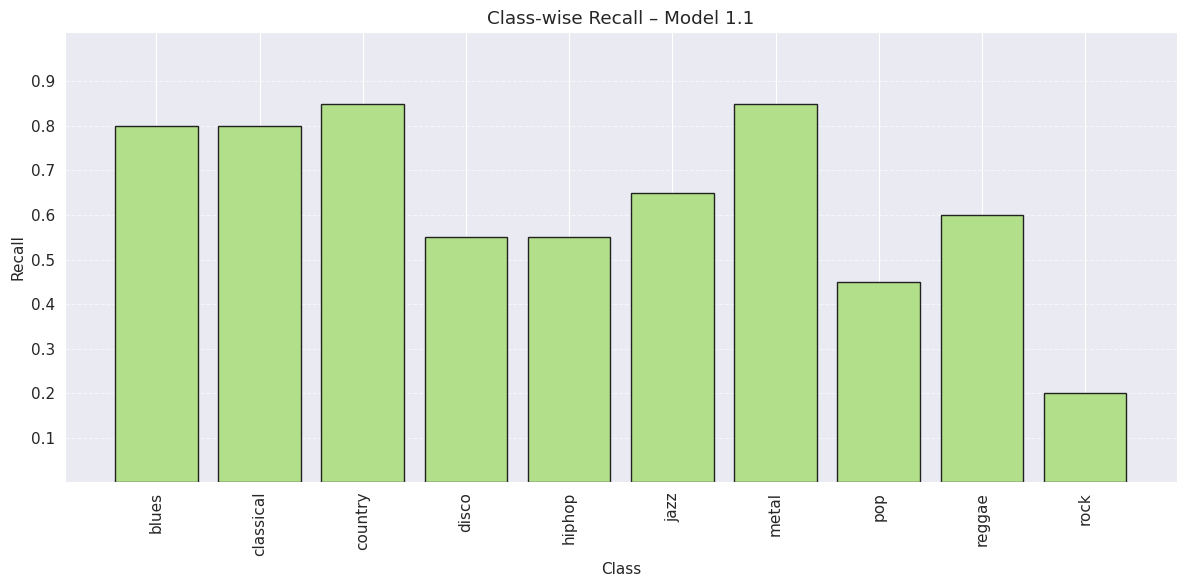

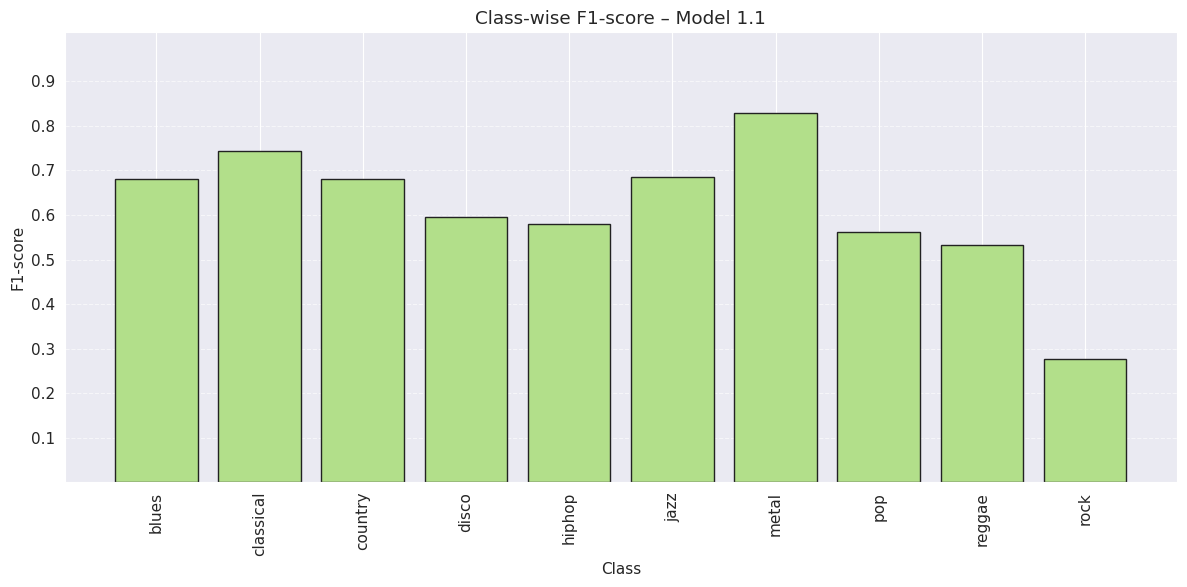

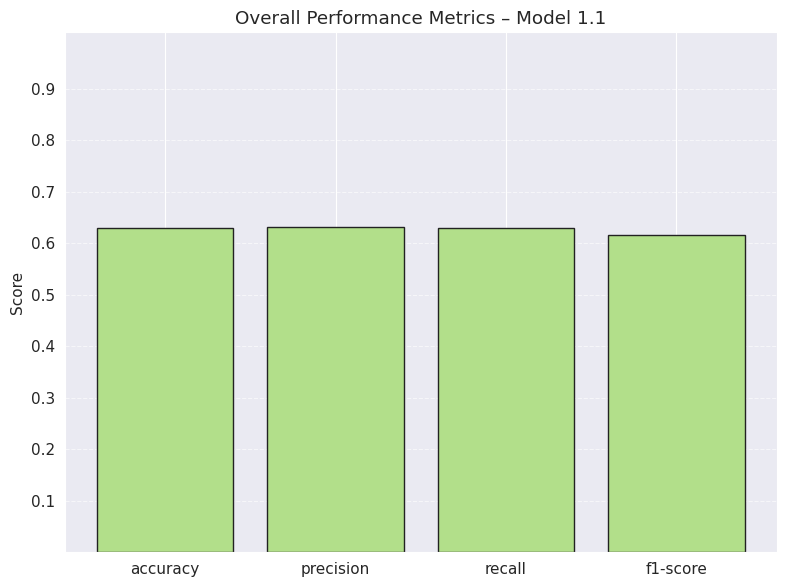

In [ ]:
# Set the current path
cur_path = BASE_PATH + "cropped"
model_version = "1.1"
model_name = "Model - " + model_version

# Load corresponding datasets
train_ds = get_dataset(cur_path + '/train', cropped_spatial_shape)
val_ds = get_dataset(cur_path + '/val', cropped_spatial_shape)
test_ds = get_dataset(cur_path + '/test', cropped_spatial_shape, False)

# Create the model
model = create_improved_CNN_archi(cropped_shape, model_version)

# Fit the model and get the report
accuracy, precision, recall, f1_score = fit_and_get_report(model, train_ds, test_ds, val_ds)

# Save the performances in the dictionary
performances[model_name] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}

plot_overall_metrics(performances[model_name], model_version)

## Model 1.2
Improved CNN architecture on Cropped Images with Data Augmentation

Found 1677 files belonging to 10 classes.
Found 140 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


Model: "1.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 212, 330, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 35, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 52, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 13, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 10, 256)     │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 731,978 (2.79 MB)

 Trainable params: 731,978 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.1198 - loss: 5.6266 - val_accuracy: 0.2286 - val_loss: 5.3823
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.1460 - loss: 5.3134 - val_accuracy: 0.2857 - val_loss: 5.0315
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.1864 - loss: 4.9937 - val_accuracy: 0.3000 - val_loss: 4.6862
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2214 - loss: 4.6984 - val_accuracy: 0.2643 - val_loss: 4.4024
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2292 - loss: 4.4570 - val_accuracy: 0.3000 - val_loss: 4.1568
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2696 - loss: 4.2187 - val_accuracy: 0.3214 - val_loss: 3.8907
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3158 - loss: 3.9406 - val_accuracy: 0.4071 - val_loss: 3.6145
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3580 - loss: 3.6925 - val_accuracy: 

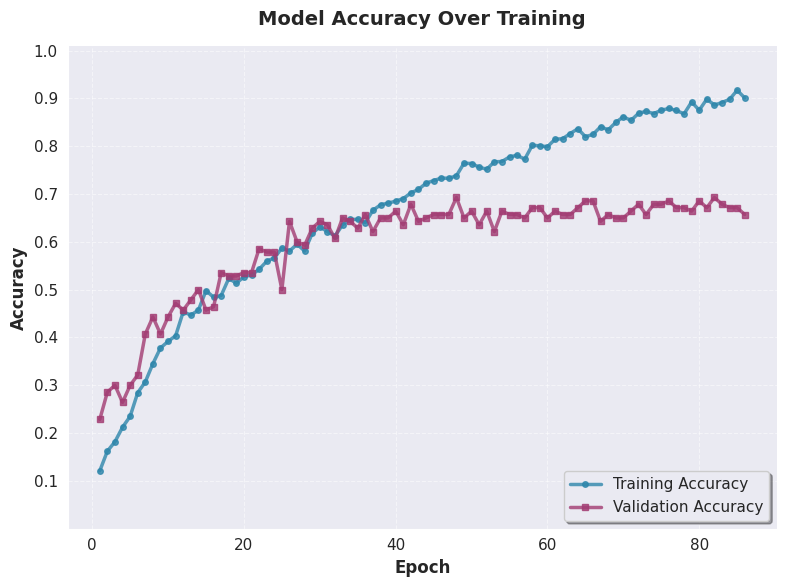

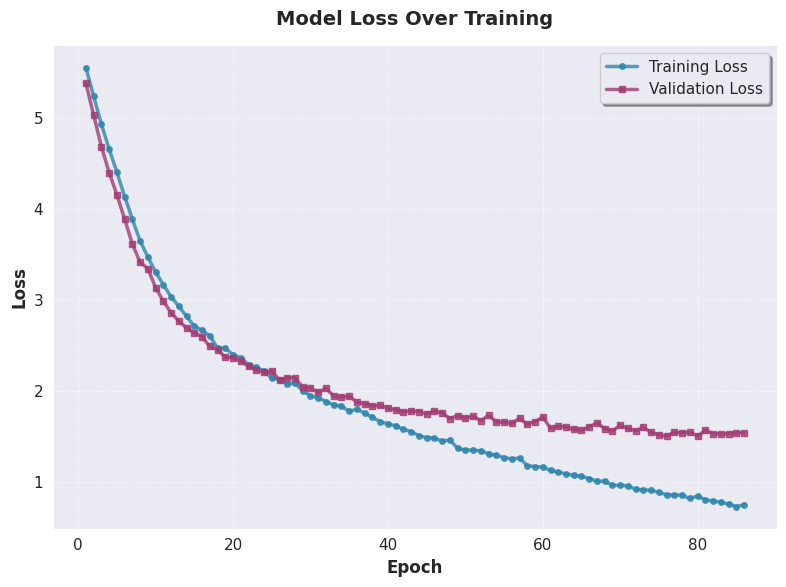

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


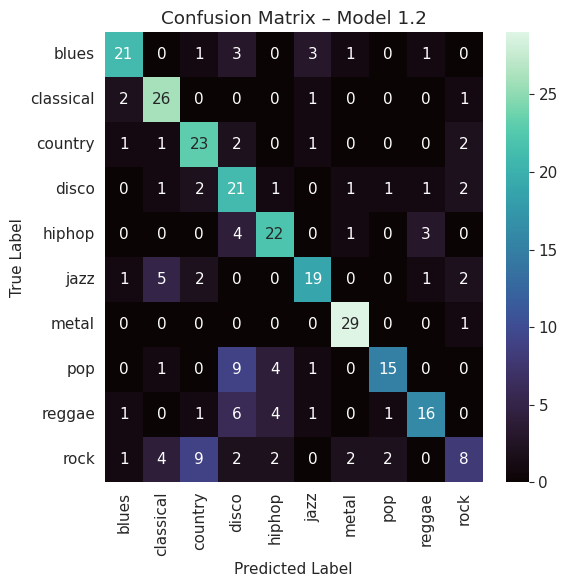

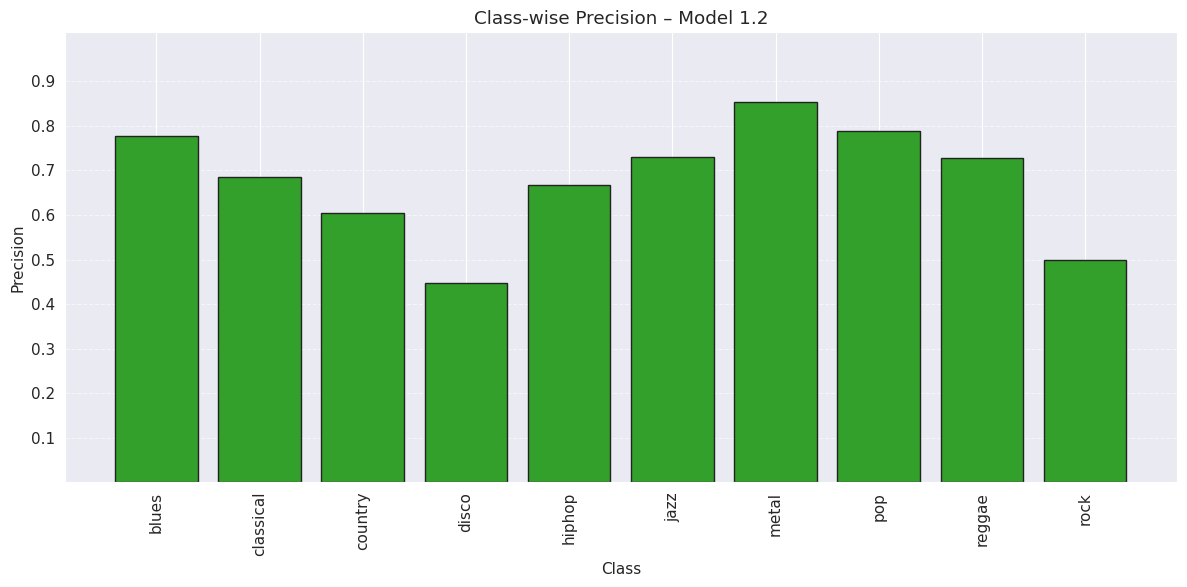

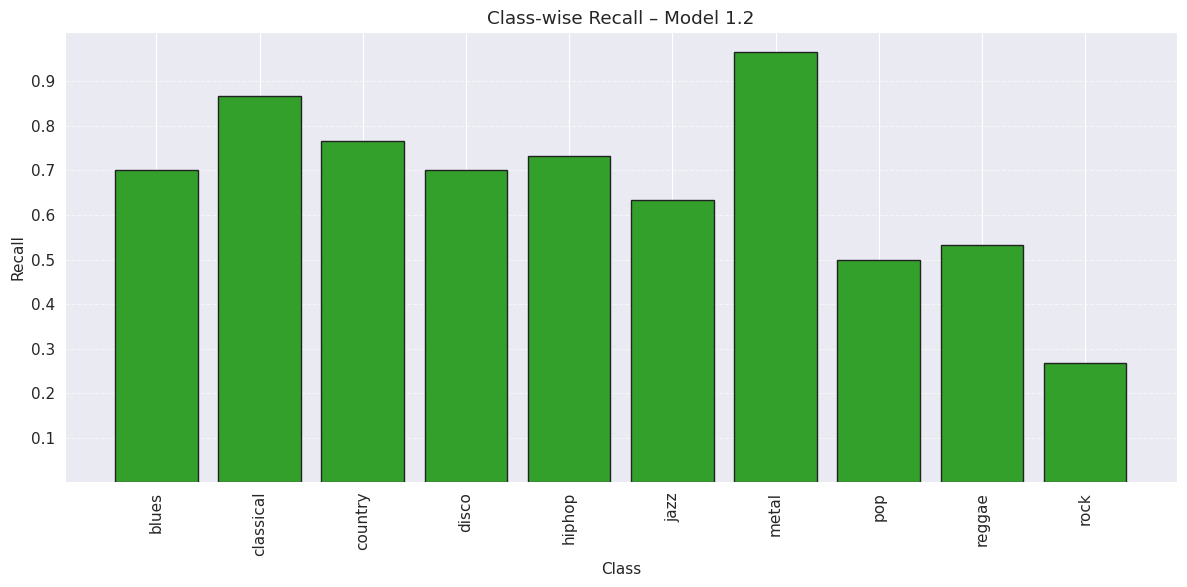

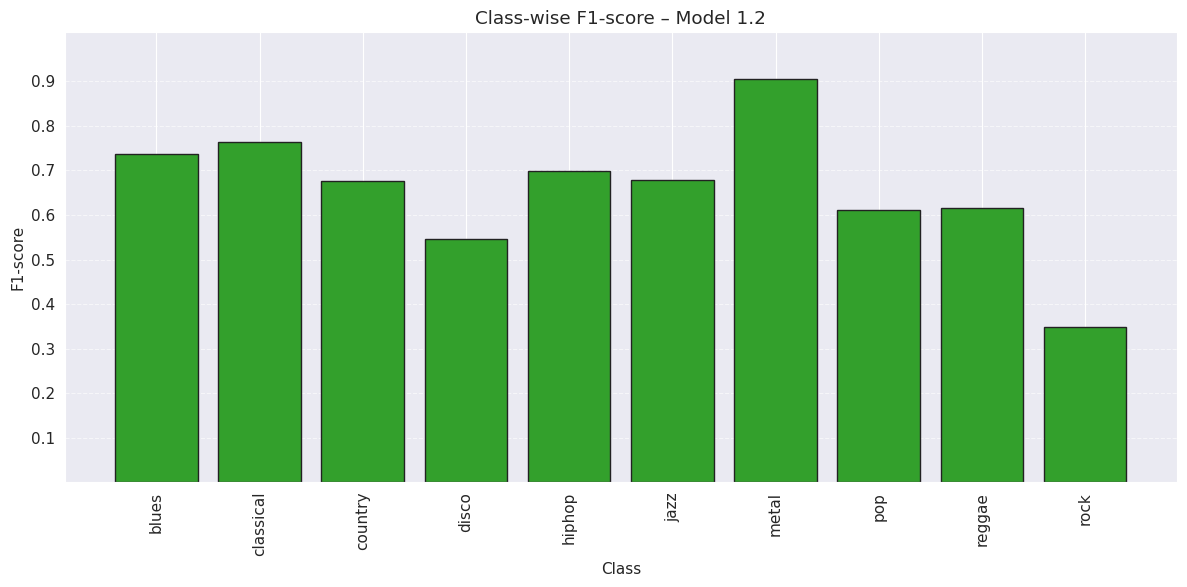

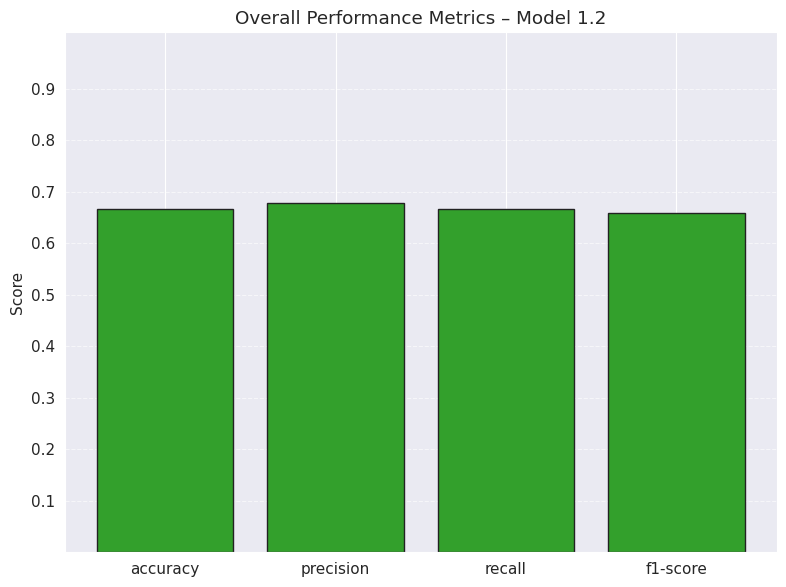

In [ ]:
# Set the current path
cur_path = BASE_PATH + "cropped_aug"
model_version = "1.2"
model_name = "Model - " + model_version

# Load corresponding datasets
train_ds = get_dataset(cur_path + '/train', cropped_spatial_shape)
val_ds = get_dataset(cur_path + '/val', cropped_spatial_shape)
test_ds = get_dataset(cur_path + '/test', cropped_spatial_shape, False)

# Create the model
model = create_improved_CNN_archi(cropped_shape, model_version)

# Fit the model and get the report
accuracy, precision, recall, f1_score = fit_and_get_report(model, train_ds, test_ds, val_ds)

# Save the performances in the dictionary
performances[model_name] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}

plot_overall_metrics(performances[model_name], model_version)

## Model 1.3
Improved CNN architecture on Cropped Images with Data Augmentation and Noise Injection

Found 3354 files belonging to 10 classes.
Found 140 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


Model: "1.3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 212, 330, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 35, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 52, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 13, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 5, 10, 256)     │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 1, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 731,978 (2.79 MB)

 Trainable params: 731,978 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.1152 - loss: 5.5405 - val_accuracy: 0.1929 - val_loss: 5.0111
Epoch 2/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.1815 - loss: 4.9045 - val_accuracy: 0.2214 - val_loss: 4.4167
Epoch 3/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.2115 - loss: 4.4097 - val_accuracy: 0.3000 - val_loss: 4.0311
Epoch 4/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.2280 - loss: 4.0423 - val_accuracy: 0.2857 - val_loss: 3.6729
Epoch 5/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.2572 - loss: 3.6861 - val_accuracy: 0.3786 - val_loss: 3.2578
Epoch 6/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.3298 - loss: 3.2940 - val_accuracy: 0.4071 - val_loss: 2.9295
Epoch 7/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.3543 - loss: 3.0168 - val_accuracy: 0.4143 - val_loss: 2.7891
Epoch 8/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4097 - loss: 2.7574 

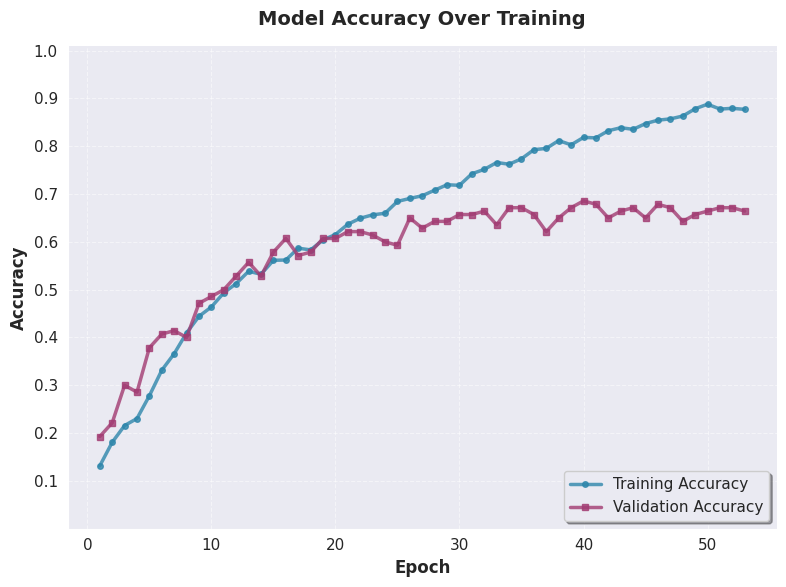

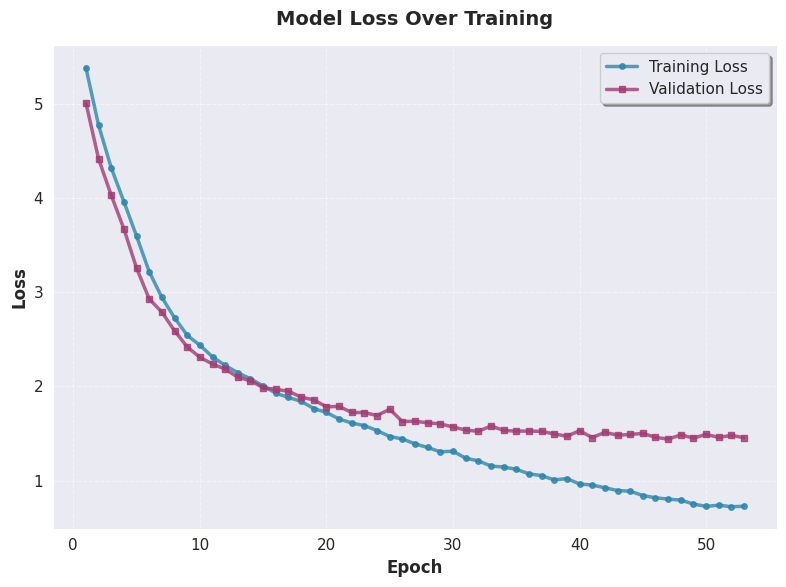

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


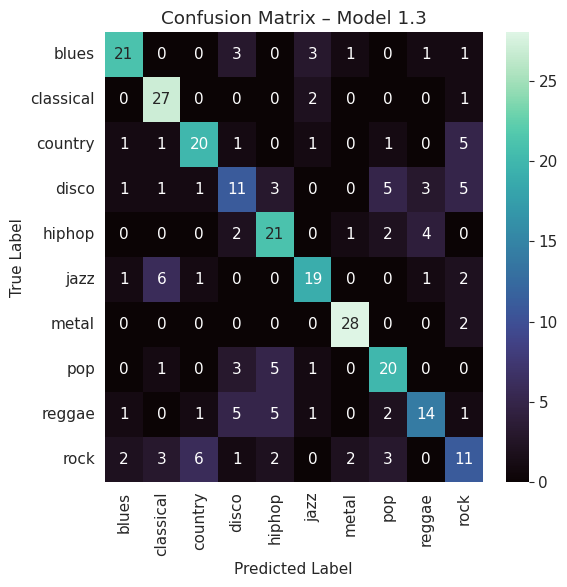

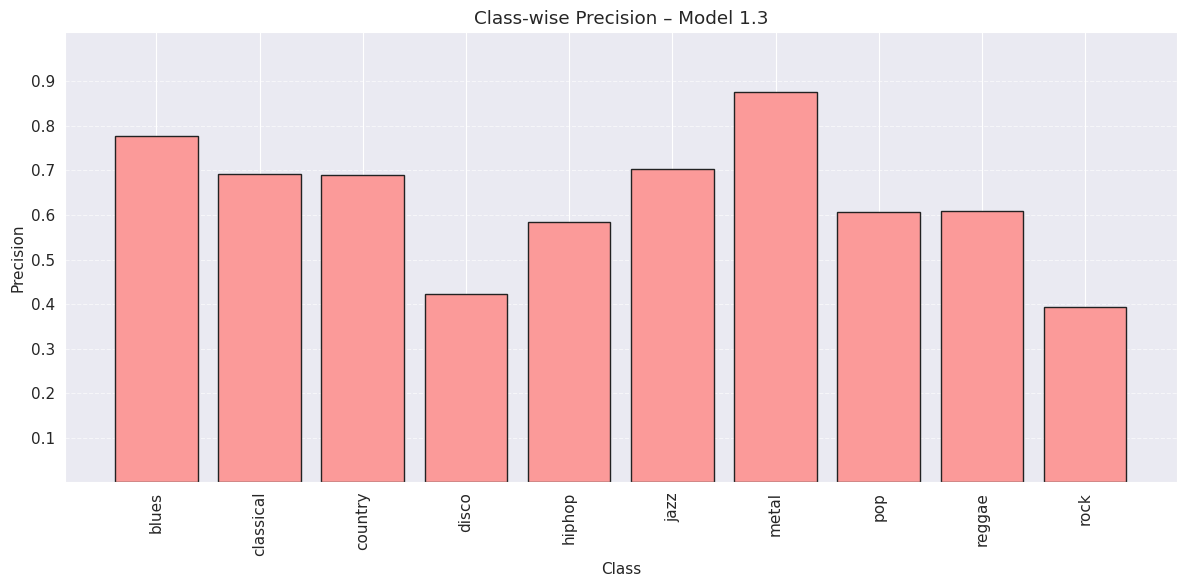

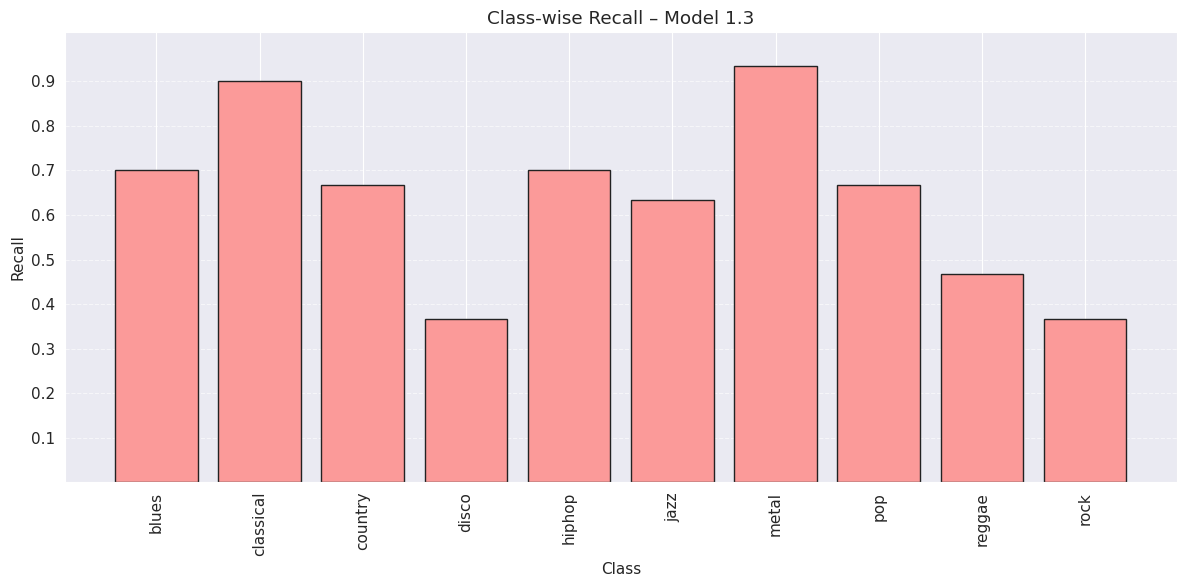

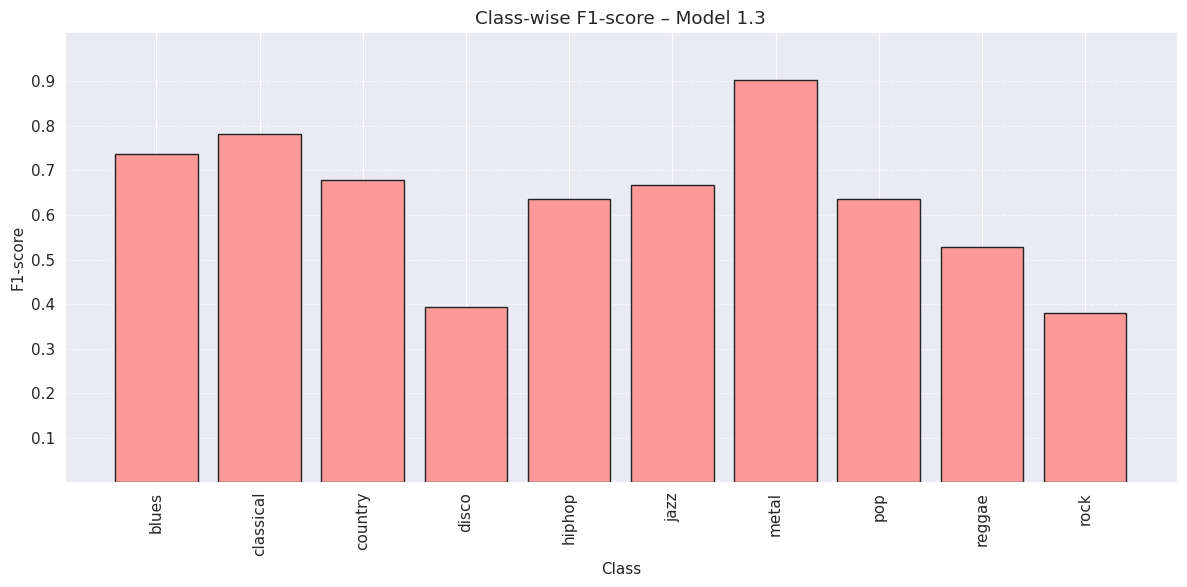

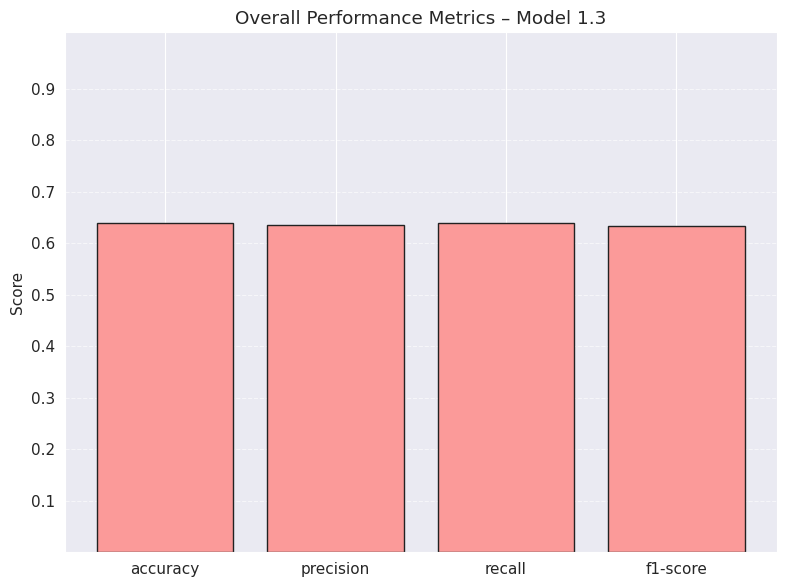

In [ ]:
# Set the current path
cur_path = BASE_PATH + "cropped_aug_inj"
model_version = "1.3"
model_name = "Model - " + model_version

# Load corresponding datasets
train_ds = get_dataset(cur_path + '/train', cropped_spatial_shape)
val_ds = get_dataset(cur_path + '/val', cropped_spatial_shape)
test_ds = get_dataset(cur_path + '/test', cropped_spatial_shape, False)

# Create the model
model = create_improved_CNN_archi(cropped_shape, model_version)

# Fit the model and get the report
accuracy, precision, recall, f1_score = fit_and_get_report(model, train_ds, test_ds, val_ds)

# Save the performances in the dictionary
performances[model_name] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}

plot_overall_metrics(performances[model_name], model_version)

## Model 1.4
Improved CNN architecture on Augmented Original Images

Found 1677 files belonging to 10 classes.
Found 140 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


Model: "1.4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 283, 427, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 47, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 44, 68, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 11, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 14, 256)     │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 2, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,050 (3.29 MB)

 Trainable params: 863,050 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.1019 - loss: 8.2514 - val_accuracy: 0.1143 - val_loss: 7.6120
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.1153 - loss: 7.4186 - val_accuracy: 0.2429 - val_loss: 6.8193
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.1667 - loss: 6.6487 - val_accuracy: 0.2571 - val_loss: 6.0777
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.1813 - loss: 5.9402 - val_accuracy: 0.2214 - val_loss: 5.3953
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.1929 - loss: 5.3329 - val_accuracy: 0.2286 - val_loss: 4.8449
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.2451 - loss: 4.8186 - val_accuracy: 0.3143 - val_loss: 4.3816
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.3049 - loss: 4.3606 - val_accuracy: 0.3571 - val_loss: 3.9580
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.3100 - loss: 3.9640 - val_accuracy: 

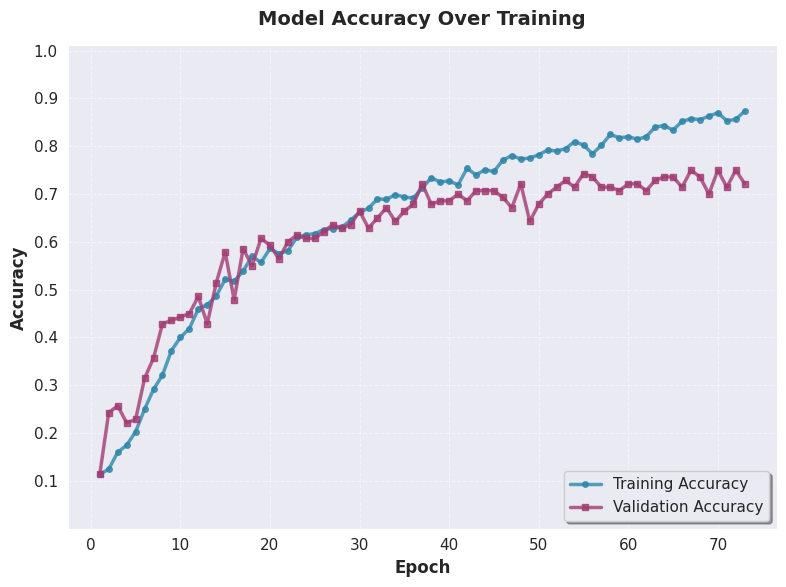

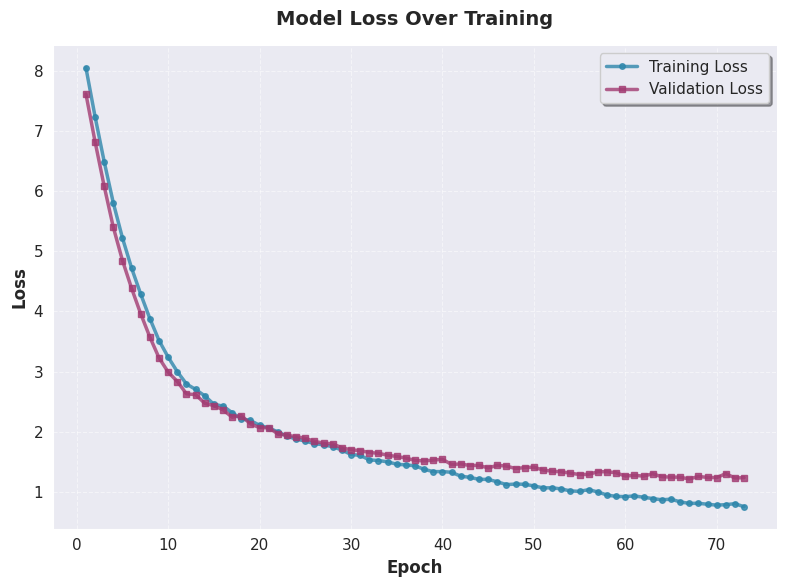

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


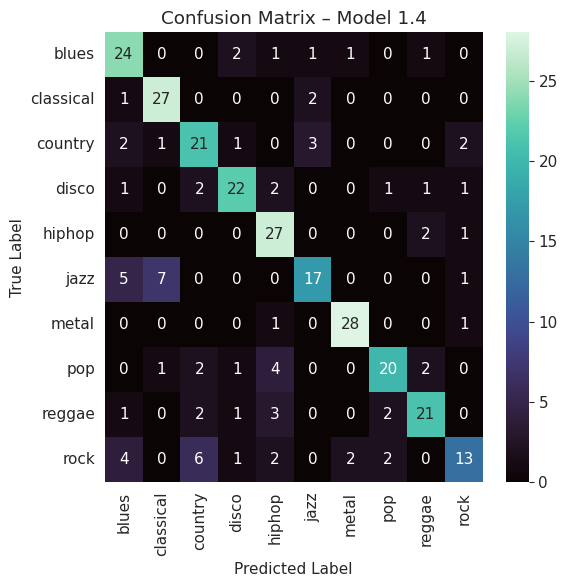

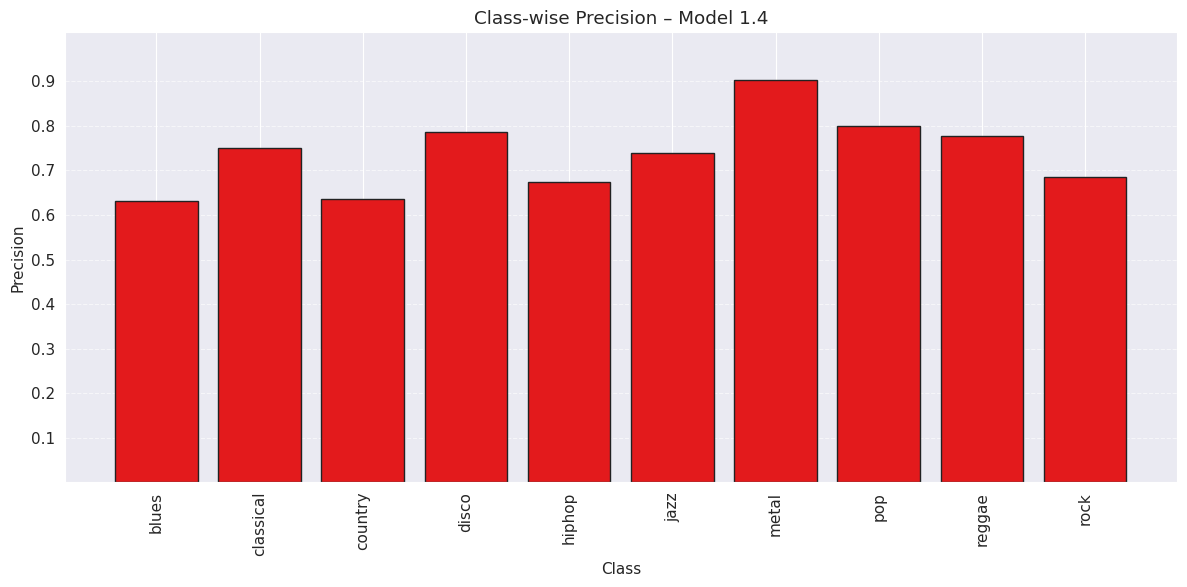

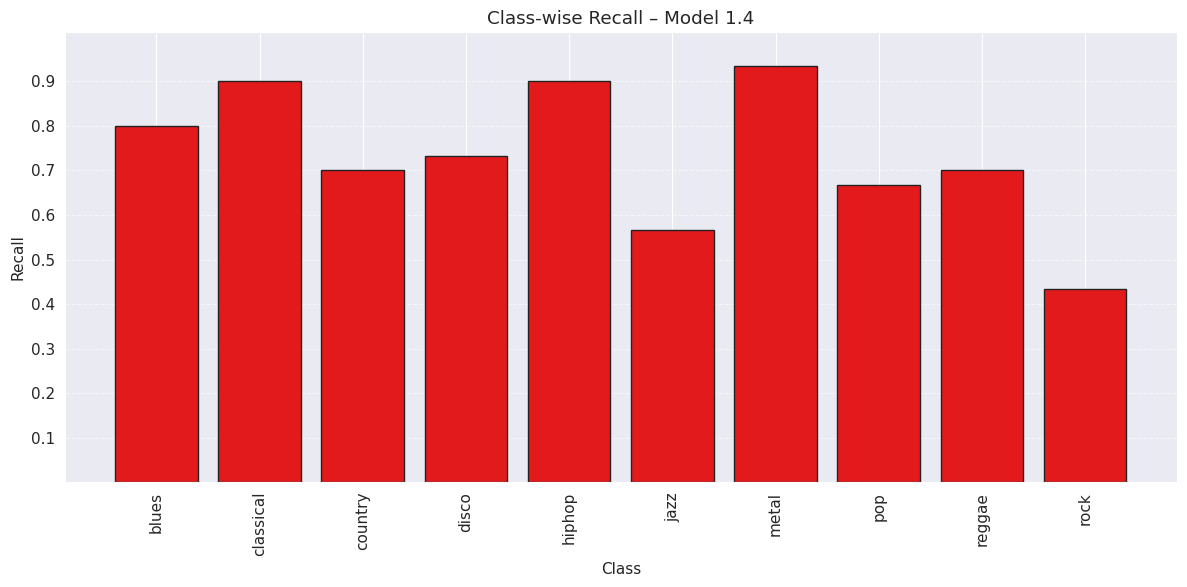

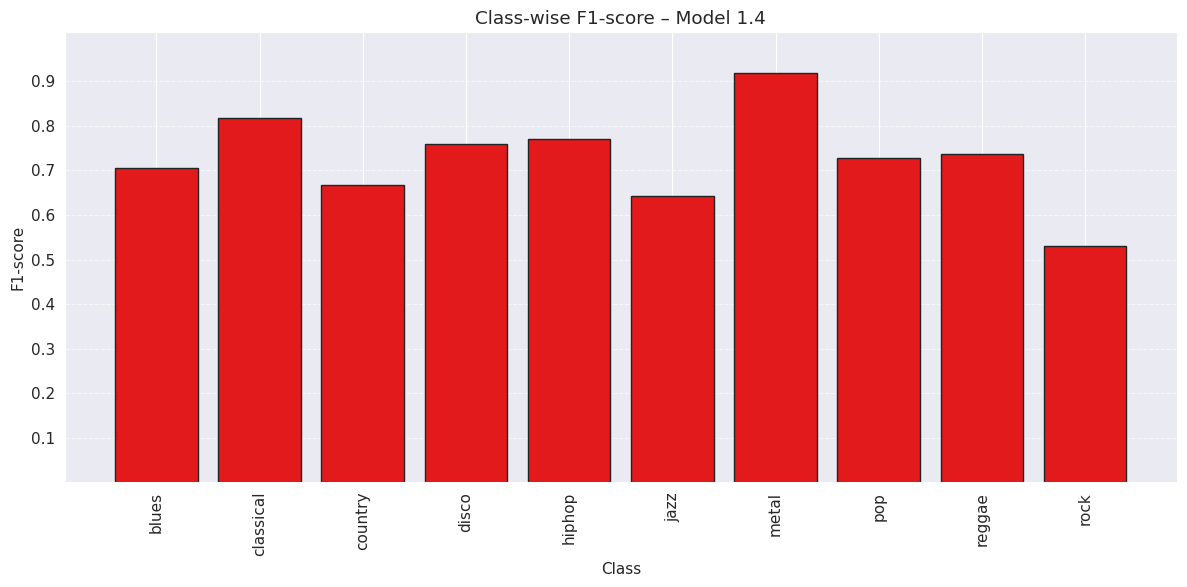

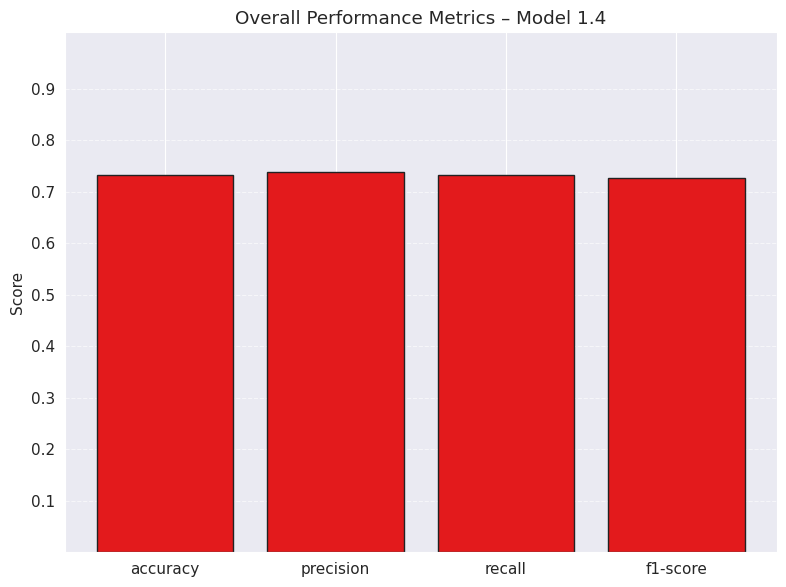

In [ ]:
# Set the current path
cur_path = BASE_PATH + "original_aug"
model_version = "1.4"
model_name = "Model - " + model_version

# Load corresponding datasets
train_ds = get_dataset(cur_path + '/train', original_spatial_shape)
val_ds = get_dataset(cur_path + '/val', original_spatial_shape)
test_ds = get_dataset(cur_path + '/test', original_spatial_shape, False)

# Create the model
model = create_improved_CNN_archi(original_shape, model_version)

# Fit the model and get the report
accuracy, precision, recall, f1_score = fit_and_get_report(model, train_ds, test_ds, val_ds)

# Save the performances in the dictionary
performances[model_name] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}

plot_overall_metrics(performances[model_name], model_version)

{'Model - 0.0': {'accuracy': 0.65, 'precision': 0.7133721359940871, 'recall': 0.65, 'f1-score': 0.6453747581015383}, 'Model - 1.0': {'accuracy': 0.71, 'precision': 0.7318564303735929, 'recall': 0.7100000000000001, 'f1-score': 0.704854270896395}, 'Model - 1.1': {'accuracy': 0.63, 'precision': 0.6319271844003304, 'recall': 0.63, 'f1-score': 0.6163753294654628}, 'Model - 1.2': {'accuracy': 0.6666666666666666, 'precision': 0.6781183458016341, 'recall': 0.6666666666666667, 'f1-score': 0.6582162848590386}, 'Model - 1.3': {'accuracy': 0.64, 'precision': 0.6352468003704885, 'recall': 0.6399999999999999, 'f1-score': 0.633906302148998}, 'Model - 1.4': {'accuracy': 0.7333333333333333, 'precision': 0.7383001414774132, 'recall': 0.7333333333333334, 'f1-score': 0.7275049397154759}}


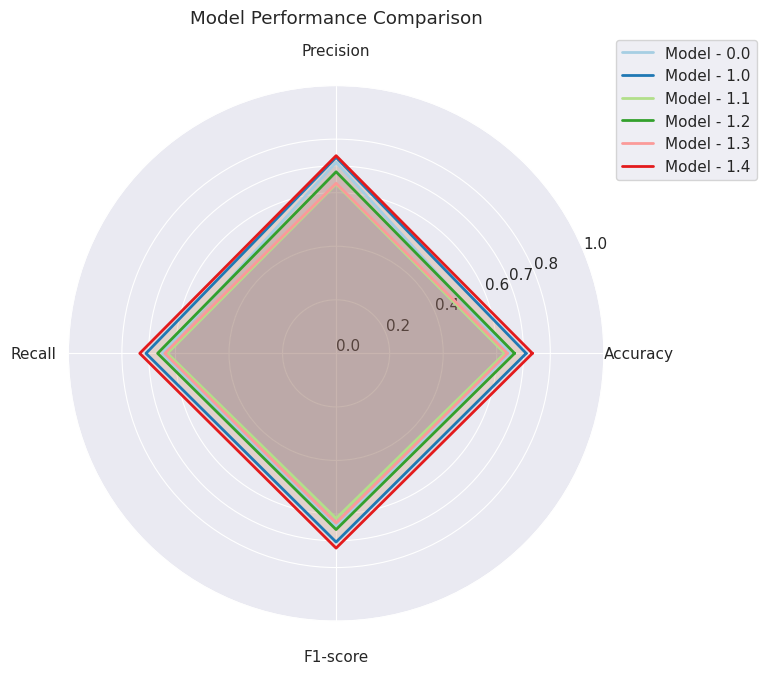

In [12]:
print(performances)
plot_model_performance_radar(performances)

In [ ]:
#model.save('/kaggle/working/CNN.keras')